In [3]:
include("smc_model.jl")
include("smc_model_parameters.jl")
using DifferentialEquations
using LaTeXStrings
using DataFrames
using Plots
using Measures
gr()

q0 = Control_params();
p0 = Fixed_params();
s0 = State();

In [2]:
import Pkg; 
Pkg.add("Measures");

  Updating registry at `C:\Users\sx59\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `C:\Users\sx59\.julia\environments\v1.2\Project.toml`
  [442fdcdd] + Measures v0.3.0
  Updating `C:\Users\sx59\.julia\environments\v1.2\Manifest.toml`
 [no changes]


# Balance the ODEs at prescribed SS

Convert parameter sets to dictionaries, and delete keys that we want to solve for

In [4]:
q0_dict = type2dict(q0);
s0_dict = type2dict(s0);

delete!(q0_dict,Symbol("g_leak_mit"));
q0_dict[Symbol("k_leak_er")] = 0.0;
#q0_dict[Symbol("g_leak_ecs")] = 0.0;
delete!(q0_dict,Symbol("g_leak_ecs"));

delete!(q0_dict,Symbol("SERCA"));
#delete!(q0_dict,Symbol("Qpmca"));
q0_dict[Symbol("Qryr")]  = .2;
q0_dict[Symbol("SERCA_s")]  = 10;
q0_dict[Symbol("Qip3r")]  = 1000;
q0_dict[Symbol("MyoTot")] = 10.0;
q0_dict[Symbol("Vnclx")] = 0.128275;
q0_dict[Symbol("Qpmca")] = 0.1033/2.2;
q0_dict[Symbol("kncx2")] = 0.1248*3;
q0_dict[Symbol("Qvocc")] = 0.1947;
q0_dict[Symbol("L")] = 0.0;


delete!(s0_dict,Symbol("IP3"));
delete!(s0_dict,Symbol("IP3RX00"));
delete!(s0_dict,Symbol("IP3RX10"));
delete!(s0_dict,Symbol("IP3RX01"));
delete!(s0_dict,Symbol("RyRR10"));
delete!(s0_dict,Symbol("RyRR11"));
delete!(s0_dict,Symbol("RyRR01"));
delete!(s0_dict,Symbol("MyoMp"));
delete!(s0_dict,Symbol("MyoAM"));
delete!(s0_dict,Symbol("MyoAMp"));
delete!(s0_dict,Symbol("G"));
delete!(s0_dict,Symbol("PIP2"));
delete!(s0_dict,Symbol("Rs"));
delete!(s0_dict,Symbol("Rsp"));

In [5]:
excludedODEs = map(v -> Symbol(v), ["Ca_ecs","Ca_er","Ca_cyt","Phi_ecs","Ca_mit_source","Ca_ecs_source"]);
includedJs = map(v -> Symbol(v), ["er_cyt","ecs_cyt"]);
s0_balanced_dict, q0_balanced_dict = balance(s0_dict,q0_dict,excludedODEs=excludedODEs,includedJs = includedJs);


In [6]:
s0_balanced_dict

Dict{Symbol,Float64} with 12 entries:
  :IP3RX00 => 0.747518
  :RyRR11  => 5.84407e-6
  :MyoMp   => 0.0186988
  :RyRR01  => 0.00177561
  :PIP2    => 118.513
  :MyoAM   => 0.060612
  :MyoAMp  => 0.0141832
  :RyRR10  => 0.00327284
  :IP3     => 0.00738113
  :IP3RX01 => 0.243054
  :IP3RX10 => 0.0048209
  :G       => 3.3199e-5

In [7]:
q0_balanced_dict

Dict{Symbol,Float64} with 3 entries:
  :g_leak_ecs => 9.69726e-5
  :SERCA      => 182.415
  :g_leak_mit => 0.0102296

In [8]:
s0_balanced = reconstruct(s0,merge(s0_dict,s0_balanced_dict));
q0_balanced = reconstruct(q0,merge(q0_dict,q0_balanced_dict));

ODEs(s0_balanced,0,q0_balanced,fix=["Ca_mit","Ca_ecs"],onlyODE=false)["J"]



DefaultOrderedDict{String,Float64,Float64} with 15 entries:
  "serca"    => -0.224302
  "ipr"      => 0.223231
  "ryr"      => 0.00107094
  "leak_er"  => 0.0
  "leak_mit" => -1.63674
  "mcu"      => -0.0226015
  "nclx_mit" => 1.65934
  "ncx_ecs"  => -0.040019
  "leak_ecs" => 0.0175167
  "pmca"     => -0.0187818
  "vocc"     => 0.041284
  "er_cyt"   => -9.65157e-16
  "mit_cyt"  => -1.11022e-16
  "ecs_cyt"  => 0.0
  "cyt_cyt"  => -0.0

# Construct and solve elevated system

In [9]:
s0_elevated = reconstruct(s0_balanced, Ca_mit = 0.25);
q0_elevated = reconstruct(q0_balanced, L=0.0)
s0_elevated_dict = type2dict(s0_elevated);

In [10]:
q0_elevated 

Control_params
  SERCA: Float64 182.41463931135567
  SERCA_s: Float64 10.0
  Qvocc: Float64 0.1947
  g_leak_mit: Float64 0.010229628206348176
  g_leak_ecs: Float64 9.697255239206481e-5
  k_leak_er: Float64 0.0
  Ca_cyt_infty: Float64 0.1
  Ca_er_infty: Float64 500.0
  ATP_infty: Float64 3000.0
  ADP_infty: Float64 10.0
  Qryr: Float64 0.2
  Qip3r: Float64 1000.0
  MyoTot: Float64 10.0
  Qncx: Float64 1.85
  Qpmca: Float64 0.04695454545454545
  Vnclx: Float64 0.128275
  Vmcu: Float64 4.398e-6
  kncx2: Float64 0.37439999999999996
  L: Float64 0.0


In [13]:
(output, problem, solution) = solveODEs(
    s0_elevated,q0_elevated,
    timespan=(0.0,60*60),
    fix = ["Ca_mit","Ca_ecs"]
    ,dtmax=100);

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:1
└ @ Core In[14]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:1
└ @ Core In[14]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:4
└ @ Core In[14]:4
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:4
└ @ Core In[14]:4
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:6
└ @ Core In[14]:6
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:6
└ @ Core In[14]:6
┌ Warning: `getindex(d

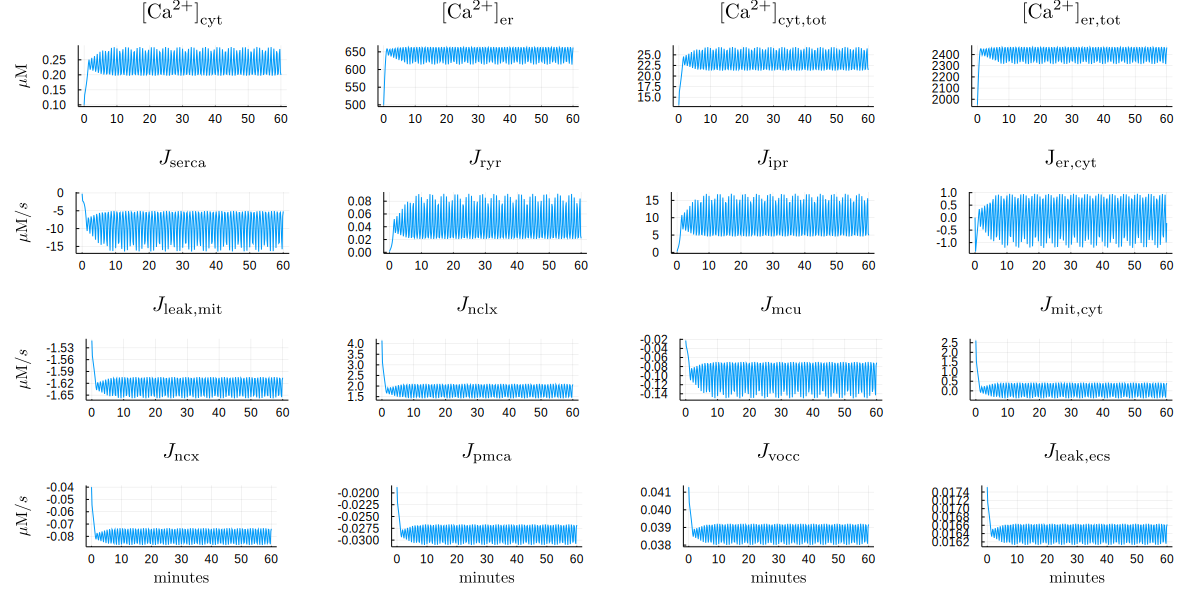

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:21
└ @ Core In[14]:21
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:24
└ @ Core In[14]:24
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:24
└ @ Core In[14]:24
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:26
└ @ Core In[14]:26
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:26
└ @ Core In[14]:26
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[14]:27
└ @ Core In[14]:27
┌ Warning:

In [14]:
p1 = plot(output[:t]/60,output[:Ca_cyt],title=L"\mathrm{[Ca^{2+}]}_{\mathrm{cyt}}",
    ylab=L"\mu\textrm{M}",
    legend=false)

p3 = plot(output[:t]/60,output[:other_Ca_cyt_tot],title=L"\mathrm{[Ca^{2+}]}_{\mathrm{cyt,tot}}",legend=false)

p2 = plot(output[:t]/60,output[:Ca_er], title=L"\mathrm{[Ca^{2+}]}_{\mathrm{er}}",legend=false)
p4 = plot(output[:t]/60,output[:other_Ca_er_tot],title=L"\mathrm{[Ca^{2+}]}_{\mathrm{er,tot}}",legend=false)

plt_ca=plot(p1,p2,p3,p4,layout=(1,4))
#savefig(plt_ca, "model_traces.png")
p1 = plot(output[:t]/60,output[:J_serca],title=L"J_{\mathrm{serca}}",legend=false,ylab=L"\mu\textrm{M}/s")
p2 = plot(output[:t]/60,output[:J_ryr],title=L"J_{\mathrm{ryr}}",legend=false)
p3 = plot(output[:t]/60,output[:J_ipr],title=L"J_{\mathrm{ipr}}",legend=false)
p4 = plot(output[:t]/60,output[:J_er_cyt],title=L"\mathrm{J}_{\mathrm{er,cyt}}",legend=false)
plt_J_er = plot(p1,p2,p3,p4,layout=(1,4))

p1 = plot(output[:t]/60,output[:J_leak_mit],title=L"J_{\mathrm{leak,mit}}",legend=false,ylab=L"\mu\textrm{M}/s")
p2 = plot(output[:t]/60,output[:J_nclx_mit],title=L"J_{\mathrm{nclx}}",legend=false)
p3 = plot(output[:t]/60,output[:J_mcu],title=L"J_{\mathrm{mcu}}",legend=false)
p4 = plot(output[:t]/60,output[:J_mit_cyt],title=L"J_{\mathrm{mit,cyt}}",legend=false)

plt_J_mit = plot(p1,p2,p3,p4,layout=(1,4))

p1 = plot(output[:t]/60,output[:J_ncx_ecs],title=L"J_{\mathrm{ncx}}",legend=false,ylab=L"\mu\textrm{M}/s")
p2 = plot(output[:t]/60,output[:J_pmca],title=L"J_{\mathrm{pmca}}",legend=false)
p3 = plot(output[:t]/60,output[:J_vocc],title=L"J_{\mathrm{vocc}}",legend=false)
p4 = plot(output[:t]/60,output[:J_leak_ecs],title=L"J_{\mathrm{leak,ecs}}",legend=false)

plt_J_ecs = plot(p1,p2,p3,p4,xlab=L"\textrm{minutes}",layout=(1,4))

plt_traces = plot(plt_ca, plt_J_er,plt_J_mit,plt_J_ecs,layout=(4,1))
plot!(size=(1200,600), margin=5mm)

display(plt_traces)

In [15]:
savefig(plt_traces, "model_traces1H.png")
savefig(plt_traces, "model_traces1H.pdf")

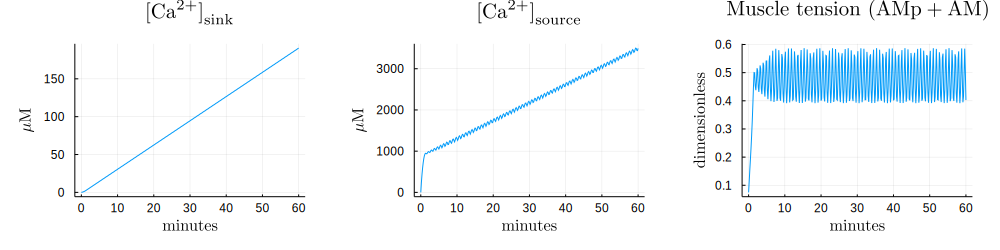

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[16]:1
└ @ Core In[16]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[16]:1
└ @ Core In[16]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[16]:3
└ @ Core In[16]:3
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[16]:3
└ @ Core In[16]:3
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[16]:5
└ @ Core In[16]:5
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[16]:5
└ @ Core In[16]:5
┌ Warning: `getindex(d

In [16]:
p1 = plot(output[:t]/60,output[:Ca_ecs_source],
    title=L"\mathrm{[Ca^{2+}]}_{\mathrm{sink}}", legend = false, ylab=L"\mu\textrm{M}")
p2 = plot(output[:t]/60,-output[:Ca_mit_source], title=L"\mathrm{[Ca^{2+}]}_{\mathrm{source}}",
    legend = false, ylab=L"\mu\textrm{M}")
p3 = plot(output[:t]/60,output[:MyoAMp] + output[:MyoAM],
    title=L"\textrm{Muscle tension (AMp} + \textrm{AM)}", legend = false, ylab=L"\textrm{dimensionless}")
plt_implications = plot(p1,p2, p3, layout = (1,3), xlab = L"\textrm{minutes}",size=(1000,250), margin=5mm)
#plot!(size=(1000,250))
display(plt_implications)

savefig(plt_implications, "implications1H.png")
savefig(plt_implications, "implications1H.pdf")

In [19]:
q0_elevated

Control_params
  SERCA: Float64 36.39583359577557
  SERCA_s: Float64 100.0
  Qryr: Float64 0.2
  Qip3r: Float64 2000.0
  Ca_er_infty: Float64 500.0
  k_leak_er: Float64 0.0
  Vnclx: Float64 0.128275
  Vmcu: Float64 4.398e-6
  g_leak_mit: Float64 0.010229628206348176
  Qncx: Float64 1.85
  Qpmca: Float64 1.0321099999999999
  Qvocc: Float64 0.19470239587882202
  kncx2: Float64 0.12480000000000002
  g_leak_ecs: Float64 0.0021307979513496373
  Ca_cyt_infty: Float64 0.1
  ATP_infty: Float64 3000.0
  ADP_infty: Float64 10.0
  MyoTot: Float64 10.0
  L: Float64 0.0


In [26]:
using CSV
CSV.write("benchmark.csv",output)

"benchmark.csv"

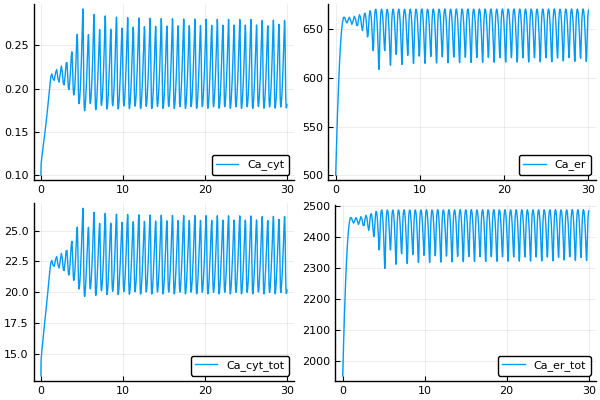

In [27]:
df = CSV.read("benchmark.csv")
p1 = plot(df[:t]/60,df[:Ca_cyt],label="Ca_cyt")
p3 = plot(df[:t]/60,df[:other_Ca_cyt_tot],label="Ca_cyt_tot")

p2 = plot(df[:t]/60,df[:Ca_er],label="Ca_er")
p4 = plot(df[:t]/60,df[:other_Ca_er_tot],label="Ca_er_tot")

plot(p1,p2,p3,p4)